In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Hide all warnings
warnings.filterwarnings('ignore')

#### Importing data

In [2]:
filepath = 'https://github.com/gr-oll/susFin/raw/refs/heads/main/Data/'

In [3]:

#returns with dididend payments yearly and monthly
Y_ret = pd.read_excel(filepath + 'DS_RI_USD_Y.xlsx')
M_ret = pd.read_excel(filepath + 'DS_RI_USD_M.xlsx')

#market value yearly and monthly
Y_mval = pd.read_excel(filepath + 'DS_MV_USD_Y.xlsx')
M_mval = pd.read_excel(filepath + 'DS_MV_USD_M.xlsx')

#revenue yearly
revenue = pd.read_excel(filepath + 'DS_REV_USD_Y.xlsx')

#risk free rate
rfr = pd.read_excel(filepath + 'Risk_Free_Rate.xlsx')

#Escores
escore = pd.read_excel(filepath + 'DS_EScore_Y.xlsx')

#Companies and Regions
companies = pd.read_excel(filepath + 'Static.xlsx')


ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

#### Only consider Pacific companies

In [ ]:
# Merge data with companies on ISIN and keep only records where Region = PAC
#   [companies['Region'].isin(['PAC'])] is used to filter the rows where Region = PAC

Y_ret = Y_ret.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
M_ret = M_ret.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
Y_mval = Y_mval.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
M_mval = M_mval.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
revenue = revenue.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
escore = escore.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')

# Drop the duplicated columns from the merge
for df in [M_ret, Y_ret, M_mval, Y_mval, revenue, escore]:
    df.drop(columns=['Region'], inplace=True)


#### Melting dataframes to have them in long format

In [ ]:
M_ret_w = M_ret.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="RETURN")
Y_ret_w = Y_ret.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="RETURN")
M_mval_w = M_mval.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="MKT_VAL")
Y_mval_w = Y_mval.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="MKT_VAL")
revenue_w = revenue.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="REVENUE")
escore_w = escore.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="ESCORE")

#### Making sure the data is correct

In [ ]:
for df in [M_ret_w, M_mval_w]:
    #change first 2 columns to string
    df['NAME'] = df['NAME'].astype(str)
    df['ISIN'] = df['ISIN'].astype(str)
    #date format d.m.y
    df['DATE'] = pd.to_datetime(df['DATE'], format='%d.%m.%Y')

for df in [Y_ret_w, Y_mval_w, revenue_w, escore_w]:
    #change first 2 columns to string
    df['NAME'] = df['NAME'].astype(str)
    df['ISIN'] = df['ISIN'].astype(str)

#### Compute Annualized returns 

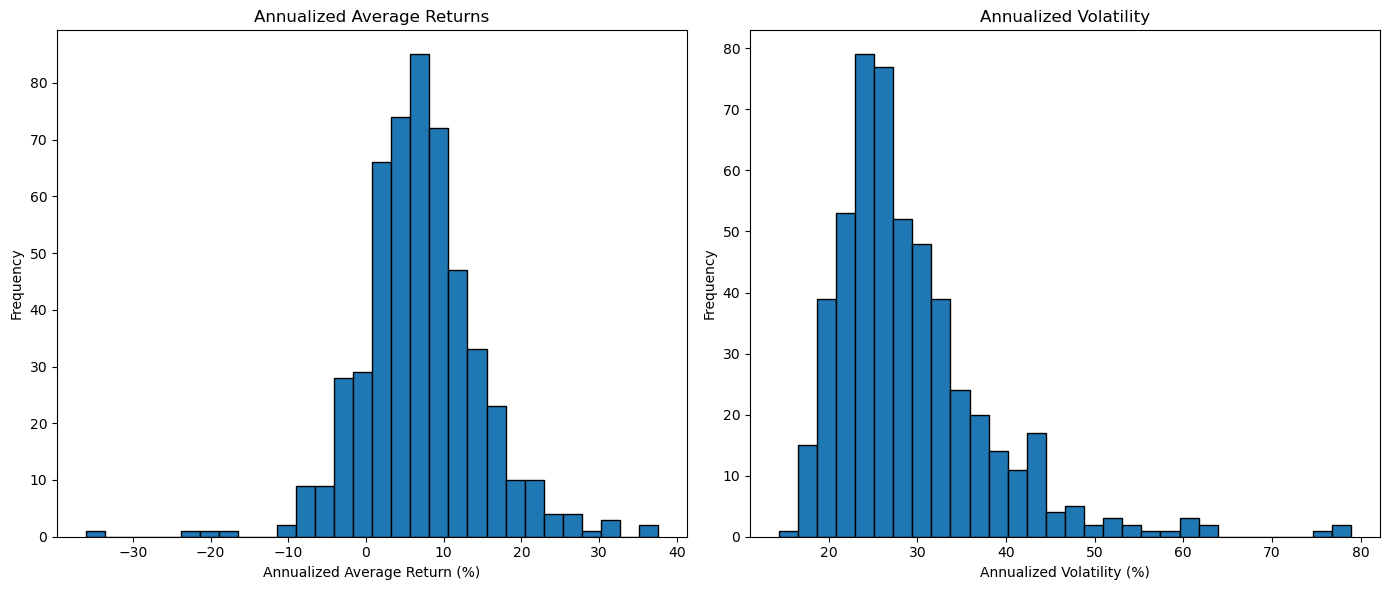

Correlation between annualized average returns and volatilities: 0.069


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Filter data from 2014 to 2024
dfe1 = M_ret_w[(M_ret_w['DATE'] >= '2013-12-31') & (M_ret_w['DATE'] <= '2024-12-31')]

# Compute monthly returns in percentage
dfe1['RET_PCT'] = dfe1.groupby('ISIN')['RETURN'].pct_change() * 100

# Drop the first row (January 2014) of each ISIN
dfe1 = dfe1.dropna(subset=['RET_PCT'])

# Compute annualized average return and annualized volatility
annualized_returns = dfe1.groupby('ISIN')['RET_PCT'].mean() * 12
annualized_volatility = dfe1.groupby('ISIN')['RET_PCT'].std() * np.sqrt(12)

# Plot histograms
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(annualized_returns, bins=30, edgecolor='k')
plt.title('Annualized Average Returns')
plt.xlabel('Annualized Average Return (%)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(annualized_volatility, bins=30, edgecolor='k')
plt.title('Annualized Volatility')
plt.xlabel('Annualized Volatility (%)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Compute correlation between individual average returns and volatilities
correlation = annualized_returns.corr(annualized_volatility)
print(f'Correlation between annualized average returns and volatilities: {correlation:.3f}')

# Comment on the results
# - Analyze the shape and spread of the histograms.
# - Discuss any notable features or outliers.
# - Interpret the correlation coefficient and its implications.

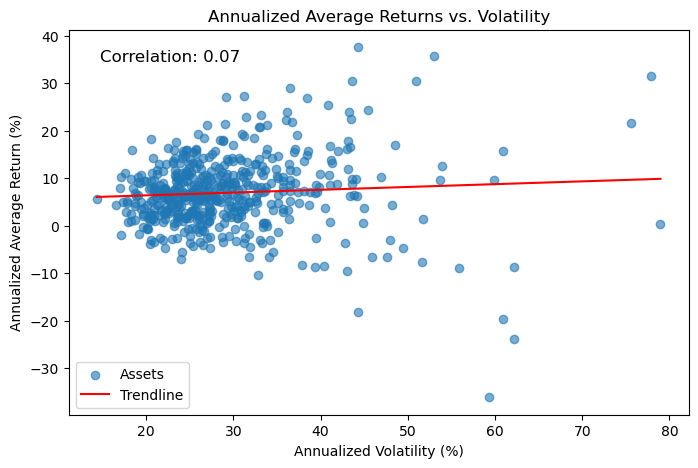

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(annualized_volatility, annualized_returns, alpha=0.6, label='Assets')
plt.title('Annualized Average Returns vs. Volatility')
plt.xlabel('Annualized Volatility (%)')
plt.ylabel('Annualized Average Return (%)')

# Compute trendline
slope, intercept = np.polyfit(annualized_volatility, annualized_returns, 1)
x = np.linspace(annualized_volatility.min(), annualized_volatility.max(), 100)
y = slope * x + intercept
plt.plot(x, y, color='red', label='Trendline')

# Display correlation
plt.text(
    0.05, 0.95,
    f'Correlation: {correlation:.2f}',
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top'
)

plt.legend()
plt.show()

In [ ]:
# Calculate equally-weighted portfolio returns
ew_returns = dfe1.groupby('DATE')['RETURN'].mean()

# Calculate value-weighted portfolio returns
dfe1 = dfe1.merge(M_mval_w[['ISIN', 'DATE', 'MKT_VAL']], on=['ISIN', 'DATE'], how='left')
dfe1['MKT_VAL'] = dfe1.groupby('DATE')['MKT_VAL'].transform(lambda x: x / x.sum())
vw_returns = (dfe1['MKT_VAL'] * dfe1['RETURN']).groupby(dfe1['DATE']).sum()

# Compute cumulative returns
ew_cum_returns = (1 + ew_returns).cumprod() - 1
vw_cum_returns = (1 + vw_returns).cumprod() - 1

# Compute statistics
def compute_stats(returns):
    annualized_return = returns.mean() * 12
    annualized_volatility = returns.std() * np.sqrt(12)
    sharpe_ratio = annualized_return / annualized_volatility
    min_return = returns.min()
    max_return = returns.max()
    return annualized_return, annualized_volatility, sharpe_ratio, min_return, max_return

ew_stats = compute_stats(ew_returns)
vw_stats = compute_stats(vw_returns)

# Print statistics
print(f'Equally-weighted portfolio statistics:')
print(f'Annualized Average Return: {ew_stats[0]:.2f}%')
print(f'Annualized Volatility: {ew_stats[1]:.2f}%')
print(f'Sharpe Ratio: {ew_stats[2]:.2f}')
print(f'Minimum Return: {ew_stats[3]:.2f}%')
print(f'Maximum Return: {ew_stats[4]:.2f}%')

print(f'\nValue-weighted portfolio statistics:')
print(f'Annualized Average Return: {vw_stats[0]:.2f}%')
print(f'Annualized Volatility: {vw_stats[1]:.2f}%')
print(f'Sharpe Ratio: {vw_stats[2]:.2f}')
print(f'Minimum Return: {vw_stats[3]:.2f}%')
print(f'Maximum Return: {vw_stats[4]:.2f}%')

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(ew_cum_returns, label='Equally-weighted Portfolio')
plt.plot(vw_cum_returns, label='Value-weighted Portfolio')
plt.title('Cumulative Returns of Portfolios (2014-2024)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()